In [1]:
###########
# IMPORTS #
###########
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
import numpy.random as rnd
import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error as skmse
from scipy import signal 
import csv
import sys
from scipy import signal as sig

###################
# GENERATOR CLASS #
###################
class GeneratorInput(object):
    
    def __init__(self, range=1):
        self.range = range
        
    def sample(self, N):
        return rnd.uniform(low=-self.range, high=self.range, size=N)


###############
# MODEL CLASS #
###############
class Model(object):
    
    def lrelu(self, x):
        return tf.maximum(x, tf.multiply(x,self.alpha))
    
    def generator(self, x, reuse, keep_prob=0.4, reg=None):
        assert self.G_out_size==1000
        with tf.variable_scope('generator', reuse=reuse) as scope:
            # Input layer
            t = tf.reshape(x,[-1,1,self.G_in_size,1])
            # Layer 1
            t = tf.layers.conv2d_transpose(inputs=t, filters=32, kernel_size=(1,5), strides=(1,2), activation=tf.nn.relu, kernel_regularizer=reg)
            t = tf.layers.dropout(t, keep_prob)
            t = tf.layers.batch_normalization(inputs=t, axis=2)
            # Layer 2
            t = tf.layers.conv2d_transpose(inputs=t, filters=16, kernel_size=(1,17), strides=(1,7), activation=tf.nn.relu, kernel_regularizer=reg)
            t = tf.layers.batch_normalization(inputs=t, axis=2)
            # Layer 3
            t = tf.layers.conv2d_transpose(inputs=t, filters=5, kernel_size=(1,8), strides=(1,3), activation=tf.nn.relu, kernel_regularizer=reg)
            t = tf.layers.dropout(t, keep_prob)
            t = tf.layers.batch_normalization(inputs=t, axis=2)
            #Layer 4
            t = tf.layers.conv2d_transpose(inputs=t, filters=1, kernel_size=(1,50), strides=(1,2), activation=tf.nn.relu, kernel_regularizer=reg)
            t = tf.layers.batch_normalization(inputs=t, axis=2)
            # Output layer
            t = tf.reshape(t, [-1,self.G_out_size])
            return t
        
    def discriminator(self, x, reuse, keep_prob=0.4, reg=None):
        assert self.G_out_size==1000
        with tf.variable_scope('discriminator', reuse=reuse) as scope:
            # Input layer
            t = tf.reshape(x,[-1,1,self.G_out_size,1])
            # Layer 1
            t = tf.layers.conv2d(inputs=t, filters=32, kernel_size=(1,20), strides=(1,2), activation=self.lrelu, kernel_regularizer=reg, padding='VALID')
            t = tf.layers.average_pooling2d(inputs=t, pool_size=(1,12), strides=1)
            t = tf.layers.dropout(t, keep_prob)
            t = tf.layers.batch_normalization(inputs=t, axis=2)
            # Layer 2
            t = tf.layers.conv2d(inputs=t, filters=16, kernel_size=(1,6), strides=(1,3), activation=self.lrelu, kernel_regularizer=reg, padding='VALID')
            t = tf.layers.average_pooling2d(inputs=t, pool_size=(1,5), strides=1)
            t = tf.layers.batch_normalization(inputs=t, axis=2)
            # Layer 3
            t = tf.layers.conv2d(inputs=t, filters=8, kernel_size=(1,17), strides=(1,6), activation=self.lrelu, kernel_regularizer=reg, padding='VALID')
            t = tf.layers.average_pooling2d(inputs=t, pool_size=(1,4), strides=1)
            t = tf.layers.dropout(t, keep_prob)
            t = tf.layers.batch_normalization(inputs=t, axis=2)
            # Layer 4
            t = tf.layers.conv2d(inputs=t, filters=1, kernel_size=(1,5), strides=(1,2), activation=self.lrelu, kernel_regularizer=reg, padding='VALID')
            t = tf.layers.average_pooling2d(inputs=t, pool_size=(1,4), strides=1)
            t = tf.layers.batch_normalization(inputs=t, axis=2)
            # Layer 5
            t = tf.layers.conv2d(inputs=t, filters=1, kernel_size=(1,2), strides=(1,4), activation=self.lrelu, kernel_regularizer=reg, padding='VALID')
            t = tf.layers.dropout(t, keep_prob)
            t = tf.layers.batch_normalization(inputs=t, axis=2)
            # Output layer
            #
            # Works better with lrelu, hypothesis: The relu clusters outputs too quickly, e.g. all outputs < 0 are zeroed out 
            #
            #t = tf.layers.dense(inputs=t,units=1, activation=self.lrelu)
            t = tf.reshape(t, [-1,2])
            return t
    
    def gen_loss(self):
        # Penalize discriminator correct identifications
        loss_main = tf.losses.softmax_cross_entropy(onehot_labels=self.label_r, logits=self.d_fake)
        # Penalize high-frequency noise
        spectrum = tf.cast(tf.abs(tf.fft(tf.cast(self.g,dtype=tf.complex64))), dtype=tf.float32)
        high_frequ_contrib = tf.gather(spectrum, tf.constant(np.array(range(500,1000))), axis=1)
        high_frequ_noise_loss = tf.reduce_mean(high_frequ_contrib)
        # Penalize negative entries, can't occur in MC scenario
        neg_entries_loss = tf.reduce_mean(tf.cast(tf.where(self.g<0),dtype=tf.float32))
        #Penalize lack of diversity
        g_differential = tf.reduce_mean(tf.abs(tf.subtract(self.g, self.prev_g)))
        diversity_lack_loss = tf.divide(tf.constant(1,dtype=tf.float32),tf.add(g_differential,tf.constant(1e-9,dtype=tf.float32)))
        loss = loss_main + self.g_loss_weights[0]*high_frequ_noise_loss + self.g_loss_weights[1]*neg_entries_loss + self.g_loss_weights[2]*diversity_lack_loss
        return loss
    
    def disc_loss(self):
        # Penalize mislabeling of real data
        loss = tf.losses.softmax_cross_entropy(onehot_labels=self.label_r, logits=self.d_real)
        # Penalize mislabeling of fake data
        loss += tf.losses.softmax_cross_entropy(onehot_labels=self.label_f, logits=self.d_fake)
        return loss
    
    def pret_loss(self):
        # Penalize mislabeling of pretraining data
        loss = tf.losses.softmax_cross_entropy(onehot_labels=self.label_pre, logits=self.d_pre)
        return loss
    
    def build_model(self):
        # Input to Tensorflow model
        self.g_in = tf.placeholder(dtype=tf.float32, shape=[None, self.G_in_size], name='g_in')
        self.d_in = tf.placeholder(dtype=tf.float32, shape=[None, self.G_out_size], name='d_in')
        self.label_pre = tf.placeholder(dtype=tf.float32, shape=[None, 2], name='label_pre')
        self.label_r = tf.placeholder(dtype=tf.float32, shape=[None,2], name='label_r')
        self.label_f = tf.placeholder(dtype=tf.float32, shape=[None,2], name='label_f')
        self.keep_prob = tf.placeholder(dtype=tf.float32, name='keep_prob')
        self.prev_g = tf.placeholder(dtype=tf.float32, shape=[None,1000], name='prev_g')
        # Regularization to limit weight gradient
        self.reg_g = tf.contrib.layers.l2_regularizer(scale=self.beta[0], scope='generator')
        self.reg_d = tf.contrib.layers.l2_regularizer(scale=self.beta[1], scope='discriminator')
        self.loss_reg_g = tf.losses.get_regularization_loss(scope='generator')
        self.loss_reg_d = tf.losses.get_regularization_loss(scope='discriminator')
        # Build generator and discriminator instances
        self.g = self.generator(self.g_in, None, self.keep_prob, reg=self.reg_g)
        self.d_pre = self.discriminator(self.d_in, None, self.keep_prob, reg=self.reg_d)
        self.d_real = self.discriminator(self.d_in, True, self.keep_prob, reg=self.reg_d)
        self.d_fake = self.discriminator(self.g, True, self.keep_prob, reg=self.reg_d)
        # Gather trainable variables
        self.vars_g = [var for var in tf.trainable_variables() if var.name.startswith('generator')]
        self.vars_d = [var for var in tf.trainable_variables() if var.name.startswith('discriminator')]
        # Losses
        self.loss_g = self.gen_loss()
        self.loss_d = self.disc_loss()
        self.loss_p = self.pret_loss()
        # Build optimizers
        self.optimizer_p = tf.train.AdamOptimizer(self.lr[0]).minimize(self.loss_p, var_list=self.vars_d)
        self.optimizer_g = tf.train.AdamOptimizer(self.lr[1]).minimize(self.loss_g+self.loss_reg_g, var_list=self.vars_g)
        self.optimizer_d = tf.train.AdamOptimizer(self.lr[2]).minimize(self.loss_d+self.loss_reg_d, var_list=self.vars_d)
        return 0
    
    def __init__(self, G_in_size, G_out_size, alpha, beta, lr, g_loss_weights=[1.2,0.5,0.1]):
        # Generator input and output size
        self.G_in_size = G_in_size
        self.G_out_size = G_out_size
        # Non-linarity factor for lrelu
        self.alpha = alpha 
        # Regularization contribution, formatting: [generator,discriminator]
        self.beta = beta
        # Learning rate, formatting: [pretraining,generator,discriminator]
        self.lr = lr
        self.g_loss_weights = g_loss_weights
        

#############
# GAN CLASS #
#############
class GAN(object):
    
    def noisify(self, in_data, sparsity=0.5, var=0.01):
        assert sparsity>0 and sparsity<1
        randlen = int(in_data.shape[1]*sparsity)
        randsig = sig.resample(var*rnd.randn(in_data.shape[0],randlen),in_data.shape[1],axis=1)
        out_data = in_data + randsig
        return out_data
        
    
    def generate_data_batch(self, testdatapath, requ_batch_size, ds_step=-1, normalization=True, return_coeffs=False):
        if ds_step<0:
            ds_step = self.ds_step
        data, obs_num, obs_len = self.load_data_as_float_array_np(testdatapath, ds_step)
        if requ_batch_size>data.shape[0]:
            if self.verbose:
                print('Insufficient data to assemble requested batch, aborting...')
            return -1
        data_out_shape = data.shape[1]
        indx_set = np.arange(data.shape[0])
        rnd.shuffle(indx_set)
        indx = indx_set[0:requ_batch_size]
        data = np.reshape(data[indx],(requ_batch_size,data_out_shape))
        if normalization:
            data,coeffs = self.norm_data(data, [0,1])
            if return_coeffs:
                return data,coeffs
            return data
        return data
    
    def generate_sample_batch(self, requ_batch_size):
        # Initialize
        try:
            saver = tf.train.Saver()
            self.sess = tf.Session()
            self.sess.run(tf.global_variables_initializer())
            saver.restore(self.sess, self.model_savepath)
        except:
            pass
        IRs = np.zeros(shape=(requ_batch_size, self.model.G_out_size))
        DISC_OUT = np.zeros(shape=(requ_batch_size, 2))
        for ctr in range(requ_batch_size):
            rand_in = self.G.sample(self.model.G_in_size)
            sample,rated = self.sess.run([self.model.g, self.model.d_fake], feed_dict={
                self.model.g_in:np.reshape(rand_in,[1,self.model.G_in_size])
            })
            IRs[ctr,:]=np.reshape(sample,[1,self.model.G_out_size])
            DISC_OUT[ctr,:]=np.reshape(rated,[1,2])
        IRs = np.reshape(IRs, (requ_batch_size, self.model.G_out_size))
        DISC_OUT = np.reshape(DISC_OUT, (requ_batch_size, 2))
        return IRs,DISC_OUT
    
    def test_compare_avg(self, testdatapath, ds_step=-1, num_gen_resp=-1, plot_out=True):
        # Initialize
        try:
            saver = tf.train.Saver()
            self.sess = tf.Session()
            self.sess.run(tf.global_variables_initializer())
            saver.restore(self.sess, self.model_savepath)
        except:
            pass
        # Load data
        if ds_step<0:
            ds_step = self.ds_step
        data, obs_num, obs_len = self.load_data_as_float_array_np(testdatapath, ds_step)
        data,_ = self.norm_data(data, [0,1])
        if num_gen_resp<0:
            num_gen_resp = obs_num
        # Average test data
        data_avg = np.mean(data, axis=0)
        # Average GAN output
        IRs = np.zeros((num_gen_resp,self.model.G_out_size))
        for ctr in range(num_gen_resp):
            rand_in = self.G.sample(self.model.G_in_size)
            #rand_in = 10*rnd.randn(model.G_in_size)+5
            sample = self.sess.run(self.model.g, feed_dict={
                self.model.g_in:np.reshape(rand_in,[1,self.model.G_in_size])
            })
            IRs[ctr,:] = np.reshape(sample, (1,self.model.G_out_size)) 
        self.sess.close()
        gan_avg = np.mean(IRs, axis=0)
        # Plot average if prompted
        if plot_out:
            plt.plot(np.reshape(data_avg,(data.shape[1],1)),'r',label='data avg')
            plt.plot(np.reshape(gan_avg,(gan_avg.shape[0],1)),'b',label='avg GAN response')
            plt.grid()
            plt.legend()
            plt.show()
        return gan_avg, data_avg, IRs
    
    def norm_data(self, mydata, myrange, use_global_max=True, use_global_min=False):
        try:
            min_norm = myrange[0]
            max_norm = myrange[1]
            if use_global_min:
                min_c = np.min(mydata)
            if use_global_max:
                max_c = np.max(mydata)
        except:
            print('Could not convert the specified range')
        scaling_coefficients = np.zeros(mydata.shape[0])
        newdata = np.zeros(mydata.shape)
        for k in range(mydata.shape[0]):
            dataline = mydata[k,:]
            if np.count_nonzero(dataline)==0:
                newdata[k,:]=dataline
                continue
            newdataline = np.zeros(dataline.shape)
            if not use_global_min:
                min_c = np.min(dataline)
            if not use_global_max:
                max_c = np.max(dataline)
            coeff = (np.abs(max_norm-min_norm)/np.abs(max_c-min_c))
            for kk in range(dataline.shape[0]):
                newdataline[kk] = min_norm + coeff*dataline[kk]
            scaling_coefficients[k]=coeff
            newdata[k,:] = newdataline
        return newdata, scaling_coefficients

    def save_current_session(self):
        saver = tf.train.Saver() 
        if self.verbose:
            print('Saving model...')
        save_path = saver.save(self.sess,self.model_savepath)
        if self.verbose:
            print('Saved model to ', save_path)
        return 0
    
    def shuffle_data(self, mydata, mylabels):
        indx = np.arange(mydata.shape[0])
        rnd.shuffle(indx)
        newdata = mydata[indx]
        newlabels = mylabels[indx]
        return newdata, newlabels
    
    def pool_data(self, S0, S1, L0, L1):
        datapool = np.append(S0, S1, axis=0)
        labelpool = np.append(L0, L1, axis=0)
        datapool, labelpool = self.shuffle_data(datapool, labelpool)
        return datapool, labelpool
    
    def make_fakeset(self, fakeset_len, obs_len):
        fakeset = np.zeros([fakeset_len,obs_len])
        if obs_len!=self.model.G_out_size:
            # TODO Implement resample
            print('TODO: Will need to resample')
            sys.exit()
        for k in range(fakeset_len):
            exc = np.reshape(self.G.sample(self.model.G_in_size),[1,self.model.G_in_size])
            g_c = self.sess.run(self.model.g, feed_dict={
                self.model.g_in:exc,
                self.model.keep_prob:1.0
            })
            fakeset[k,:] = np.reshape(g_c, [1,obs_len])
        fakelabels = np.append(np.ones([fakeset_len,1]), np.zeros([fakeset_len,1]), axis=1)
        return fakeset, fakelabels
    
    def make_dataset(self, data):
        dataset = data
        datalabels = np.append(np.zeros([data.shape[0],1]), np.ones([data.shape[0],1]), axis=1)
        return dataset, datalabels
    
    def close(self):
        if self.verbose:
            print('Closing session...')
        print('TODO: Prompt save request here')
        # TODO Save model
        self.sess.close()
        return 0
    
    def load_data_as_float_array_np(self, path, ds_step=1, skip_header_line=False,resample_to_gen_len=True):
        try:
            in_f = open(path)
            reader = csv.reader(in_f, delimiter=',', quoting = csv.QUOTE_NONE)
            in_data = np.array(list(reader)).astype('float')
            in_f.close()
        except:
            print('Failed to open file, retrying...')
        try:    
            in_f = open(path)
            reader = csv.reader(in_f, delimiter=',', quoting = csv.QUOTE_NONNUMERIC)
            created_list = False
            for line in np.array(list(reader)):
                new_line = []
                for v in line:
                    try:
                        new_line.append(float(v))
                    except:
                        pass
                if created_list:
                    in_data = np.vstack([in_data,new_line])
                else:
                    in_data = np.empty(shape=(1,len(new_line)))
                    created_list = True
            in_f.close()
        except:
            print('File cannot be opened...')
            return -1, 0, 0
        data = in_data[:,::ds_step]
        if skip_header_line:
            data = data[1:,:]
        obs_num, obs_len = data.shape
        if self.model.G_out_size!=obs_len and resample_to_gen_len:
            if self.verbose:
                print('Data does not fit generator, resampling...')
            data = signal.resample(data, self.model.G_out_size, axis=1)
            obs_len = data.shape[1]
        return data, obs_num, obs_len
    
    def pretrain(self, datapath, batch_size_pretrain=1):
        # Initialize
        if self.verbose:
            print('Initializing...')
        data, obs_num, obs_len = self.load_data_as_float_array_np(datapath,self.ds_step)
        data,_ = self.norm_data(data, [0,1])
        # Make pretraining labeled data
        realdata, reallabels = self.make_dataset(data)
        fakedata, fakelabels = self.make_fakeset (obs_num, obs_len)
        datapool, labelpool = self.pool_data(realdata, fakedata, reallabels, fakelabels)
        # Noisify pretraining data if prompted
        if self.noisify_data:
            datapool = self.noisify(datapool)
        # Loss tracker
        pretrain_loss_tracker = np.zeros([1,int(obs_num/batch_size_pretrain)])
        # Begin training
        if self.verbose:
            print('Pretraining the discriminator...') 
        # Perform training and track loss
        for k in range(int(obs_num/batch_size_pretrain)):
            o_p,d_p,lab_p,l_p = self.sess.run([self.model.optimizer_p, self.model.d_pre, self.model.label_pre, self.model.loss_p], feed_dict={
                self.model.d_in:np.reshape(datapool[(k*batch_size_pretrain):((k+1)*batch_size_pretrain),:], [batch_size_pretrain, self.model.G_out_size]),
                self.model.label_pre:np.reshape(labelpool[(k*batch_size_pretrain):((k+1)*batch_size_pretrain),:],[batch_size_pretrain,2]),
                self.model.keep_prob:0.6
            })
            l_avg = np.mean(l_p)
            pretrain_loss_tracker[0,k] = l_avg
            if self.debugging:
                print('Iteration ', k)
                print('Label true: ', lab_p)
                print('Label pred: ', d_p)
                print('Loss: ', l_p)
        # Report success
        if self.verbose:
            plt.plot(pretrain_loss_tracker[0,:])
            plt.title('Loss tracker')
            plt.show()
            print('Done!\n')
        self.is_pretrained=True
        return pretrain_loss_tracker
    
    def train(self, datapath, check_for_cont=False, filter_gen=False, examine_sample=30, lp_filter_len=10):
        # Load data
        if self.verbose:
            print('Loading data and initializing, this may take a while...')
        if check_for_cont:
            self.save_intermediate = True
            assert self.ckpt_savepath!=''
        data, obs_num, obs_len = self.load_data_as_float_array_np(datapath,self.ds_step)
        assert obs_len==self.model.G_out_size
        # Fit data
        if self.verbose:
            print('Normalizing data...')
        data,_ = self.norm_data(data, [0,1])
        
        # Initialize
        saver = tf.train.Saver()
        next_data_unused = 0
        last_save_step = 0
        num_restore = 0
        training_steps = int(obs_num/self.batch_size)
        save_step = int(training_steps/self.save_sample)        
        examine_step = int(training_steps/examine_sample)
        # Loss trackers
        g_train_loss_tracker = np.zeros([1,training_steps])
        d_train_loss_tracker = np.zeros([1,training_steps])
        # Launch training
        previous_g_input = np.zeros([self.batch_size, self.model.G_out_size])
        if self.verbose:
            print('Launched training phase with {0} iterations, working...'.format(training_steps))
        for k in range(training_steps):
            # Save model if prompted
            if self.save_intermediate and k%save_step==0:
                print('Saving...')
                last_save_step = k
                save_path = saver.save(self.sess,self.ckpt_savepath+str(k)+'.ckpt')
                print('Saved intermediate version to ', save_path)
            # Make a fake batch
            gg = np.reshape(self.G.sample(self.model.G_in_size), [1,self.model.G_in_size])
            for kk in range(self.batch_size-1):
                gg = np.append(gg, np.reshape(self.G.sample(self.model.G_in_size),[1,self.model.G_in_size]))
            labels_fake = np.append(np.ones([self.batch_size,1]), np.zeros([self.batch_size,1]), axis=1)
            try:
                dd, labels_real = self.make_dataset(data[next_data_unused:next_data_unused+self.batch_size,:])
            except:
                print('Reached end of available training data, exiting training process...')
                break
            next_data_unused += self.batch_size
            # Noisify data if prompted
            if self.noisify_data:
                dd = self.noisify(dd)
            # Train generator
            o_g, l_g, my_g = self.sess.run([self.model.optimizer_g, self.model.loss_g, self.model.g], feed_dict={
                self.model.g_in:np.reshape(gg,(self.batch_size, self.model.G_in_size)),
                self.model.label_r:np.reshape(labels_real,[self.batch_size,2]),
                self.model.keep_prob:0.5,
                self.model.prev_g:np.reshape(previous_g_input,[self.batch_size,self.model.G_out_size])
            })
            # Train discriminator
            o_d, l_d, my_g = self.sess.run([self.model.optimizer_d, self.model.loss_d, self.model.g], feed_dict={
                self.model.g_in:np.reshape(gg,(self.batch_size, self.model.G_in_size)),
                self.model.d_in:np.reshape(dd,(self.batch_size, self.model.G_out_size)),
                self.model.label_r:np.reshape(labels_real,[self.batch_size,2]),
                self.model.label_f:np.reshape(labels_fake,[self.batch_size,2]),
                self.model.keep_prob:0.5
            })
            previous_g_input = my_g
            # Loss average
            l_g_avg = np.mean(l_g)
            l_d_avg = np.mean(l_d)
            g_train_loss_tracker[0,k] = l_g_avg
            d_train_loss_tracker[0,k] = l_d_avg
            # Check for continuity in loss tracking
            if check_for_cont:
                if k>save_step and num_restore<self.max_restore:
                    g_loss_grad = np.gradient(g_train_loss_tracker[0,0:k])
                    d_loss_grad = np.gradient(d_train_loss_tracker[0,0:k])
                    if np.abs(g_loss_grad[-1])>self.max_grad_dev or np.abs(d_loss_grad[-1])>self.max_grad_dev:
                        if self.verbose:
                            print('Loss discontinuity detected, trying to restore last working checkpoint...')
                        k = last_save_step
                        saver.restore(self.sess, self.ckpt_savepath+str(k)+'.ckpt')
                        num_restore += 1
                        if self.verbose:
                            print('Successfully restored last checkpoint!')
            num_restore = 0
            # Output results if prompted
            if self.verbose and k%examine_step==0:
                print('Generator output in iteration ', k)
                plt.plot(my_g[0,:])
                plt.show()
                if filter_gen:
                    print('Lowpass filtering yields:')
                    plt.plot(sig.lfilter(np.ones(lp_filter_len),[1],my_g[0,:])/lp_filter_len)
                    plt.show()
            if self.debugging:
                print('Iteration ', k, ' of ', self.training_steps)
                print('Batch should be : ', self.batch_size, '-by-', self.model.G_out_size)
                print('Batch really is : ', dd.shape[0], '-by-', dd.shape[1])
                print('Avg G loss: ', l_g_avg)
                print('Avg D loss: ', l_d_avg)
                print('Iteration {0} of {1}:\n\t --> loss gen = {2}\n\t --> loss disc = {3}'.format(k,self.training_steps,l_g_avg,l_d_avg))
        # Output loss
        if self.verbose:
            fig, (ax0, ax1) = plt.subplots(1,2)
            ax0.plot(d_train_loss_tracker[0,:])
            ax1.plot(g_train_loss_tracker[0,:])
            plt.title('DISCR and GENER loss progress during training')
            plt.show()
            print('Done training!')
            print('The discriminator should output 1 for fakes and 0 for real impulse responses.')
        # Save final model
        assert self.save_current_session()==0
        # Evaluate loss gradients
        grad_g = np.gradient(g_train_loss_tracker, axis=1)
        grad_d = np.gradient(d_train_loss_tracker, axis=1)   
        if self.verbose:
            print('Session closed, all done!')
            print('Training progress and gradients:\n')
            plt.plot(g_train_loss_tracker[0,:])
            plt.show()
            plt.plot(d_train_loss_tracker[0,:])
            plt.show()
            plt.plot(grad_g[0,:])
            plt.show()
            plt.plot(grad_d[0,:])
            plt.show()
        # Done
        if self.verbose:
            print('All done, goodbye!')
        self.is_trained = True
        self.close()
        return data
        
    def __init__(self, mID, verbose=True, batch_size=3, seed=1, debugging=False, save_intermediate=True, 
                 save_sample=10, lp_filter_len=20, data_downsample=1, max_grad_dev=2, 
                 max_restore=5, alpha=0.2, myseed=1, noisify_data=True):
        # Initialize generator:
        self.G = GeneratorInput()
        # Output:
        self.verbose = verbose
        self.debugging = debugging
        self.save_intermediate = save_intermediate
        # Model directory and data path:
        self.mID = mID
        # Examine .. samples in total:
        #self.examine_sample = examine_sample
        # Store .. models in total:
        self.save_sample = save_sample
        # Batch size during training and number of data elements reserved for pretraining:
        self.batch_size = batch_size
        # Lowpass filter for better representation, filter length:
        self.lp_filter_len = lp_filter_len
        self.ds_step = data_downsample
        # Maximum allowed loss gradient and allowed attempts for model reset:
        self.max_grad_dev = max_grad_dev
        self.max_restore = max_restore
        # Random generator seed:
        self.myseed = myseed
        # Set up folder structure:
        self.base_dir = 'model_dir'
        self.ckpt_dir = self.base_dir+'\\chkpts\\m'+self.mID
        self.ckpt_savepath = self.ckpt_dir+'\\mymodel_ckpt_iter'
        self.model_savepath = self.base_dir+'\\final\\model'+mID+'.ckpt'
        # Initialize:
        rnd.seed(self.myseed)
        tf.reset_default_graph()
        # Build model:
        self.model = Model(G_in_size=9, G_out_size=1000, alpha=alpha, beta=[0.5,0.5], lr=[0.001,0.001,0.001])
        self.model.build_model()
        # Initialize session:
        self.sess = tf.Session()
        self.sess.run(tf.global_variables_initializer())
        self.is_pretrained = False
        self.is_trained = False
        self.noisify_data = noisify_data
        # Check consistency and report okay if prompted
        if not self.verbose:
            self.filter_gen = False
        if self.verbose:
            print('GAN has been set up and is ready!')

C:\Users\Jan\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
use_arman_data = False
use_IR_data = True

GAN has been set up and is ready!
Initializing...
Data does not fit generator, resampling...
Pretraining the discriminator...


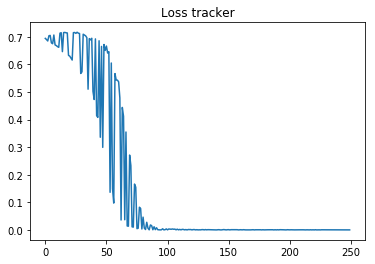

Done!



In [6]:
assert use_arman_data!=use_IR_data

if use_IR_data:
    pretraining_path = 'gandata\\IR_pretrain.csv'
    training_path = 'gandata\\IR_train.csv'
    testdata_path = 'gandata\\IR_test.csv'

if use_arman_data: 
    pretraining_path = 'gandata\\ARMAN_pretrain.csv'
    training_path = 'gandata\\ARMAN_train.csv'
    testdata_path = 'gandata\\ARMAN_test.csv'

gan = GAN('006')

if use_IR_data:
    ptlt = gan.pretrain(pretraining_path)

Loading data and initializing, this may take a while...
Data does not fit generator, resampling...
Normalizing data...
Launched training phase with 3666 iterations, working...
Saving...
Saved intermediate version to  model_dir\chkpts\m006\mymodel_ckpt_iter0.ckpt
Generator output in iteration  0


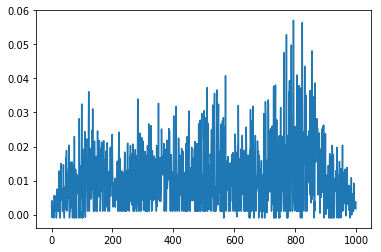

Saving...
Saved intermediate version to  model_dir\chkpts\m006\mymodel_ckpt_iter366.ckpt
Generator output in iteration  366


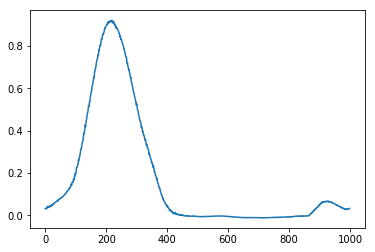

Saving...
Saved intermediate version to  model_dir\chkpts\m006\mymodel_ckpt_iter732.ckpt
Generator output in iteration  732


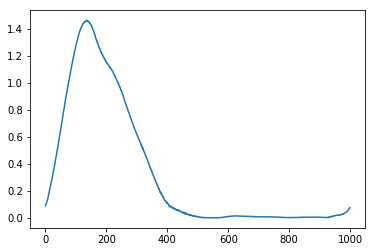

Saving...
Saved intermediate version to  model_dir\chkpts\m006\mymodel_ckpt_iter1098.ckpt
Generator output in iteration  1098


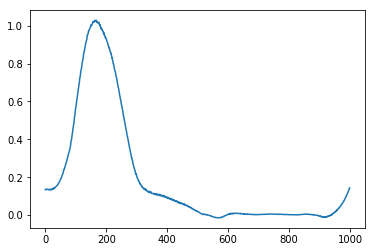

Saving...
Saved intermediate version to  model_dir\chkpts\m006\mymodel_ckpt_iter1464.ckpt
Generator output in iteration  1464


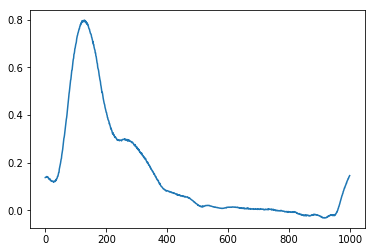

Saving...
Saved intermediate version to  model_dir\chkpts\m006\mymodel_ckpt_iter1830.ckpt
Generator output in iteration  1830


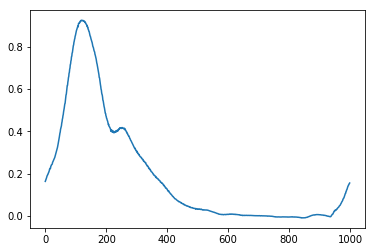

Saving...
Saved intermediate version to  model_dir\chkpts\m006\mymodel_ckpt_iter2196.ckpt
Generator output in iteration  2196


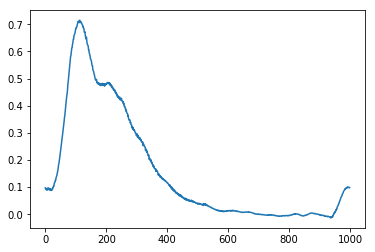

Saving...
Saved intermediate version to  model_dir\chkpts\m006\mymodel_ckpt_iter2562.ckpt
Generator output in iteration  2562


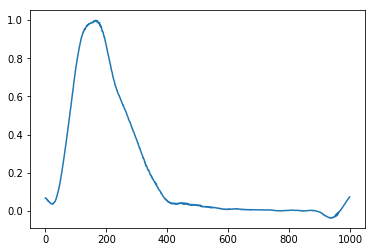

Saving...
Saved intermediate version to  model_dir\chkpts\m006\mymodel_ckpt_iter2928.ckpt
Generator output in iteration  2928


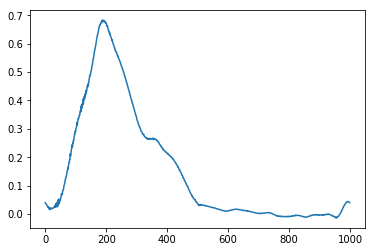

Saving...
Saved intermediate version to  model_dir\chkpts\m006\mymodel_ckpt_iter3294.ckpt
Generator output in iteration  3294


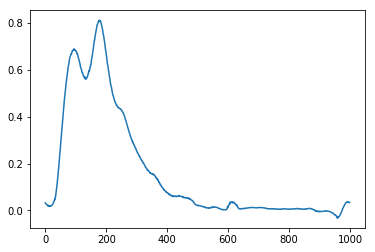

Saving...
Saved intermediate version to  model_dir\chkpts\m006\mymodel_ckpt_iter3660.ckpt
Generator output in iteration  3660


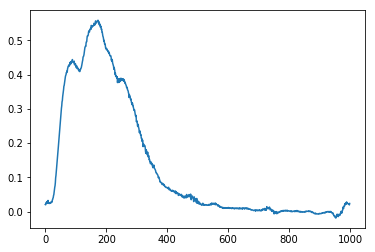

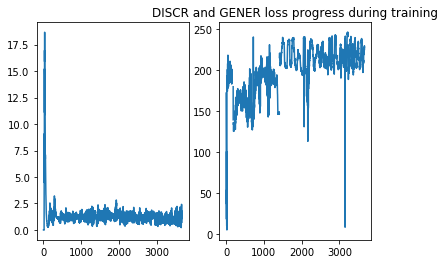

Done training!
The discriminator should output 1 for fakes and 0 for real impulse responses.
Saving model...
Saved model to  model_dir\final\model006.ckpt
Session closed, all done!
Training progress and gradients:



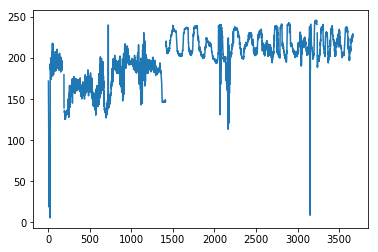

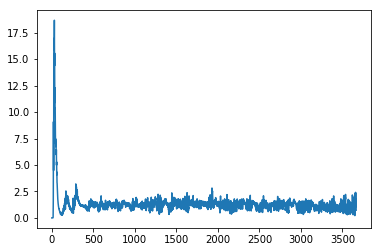

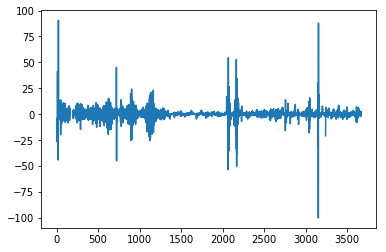

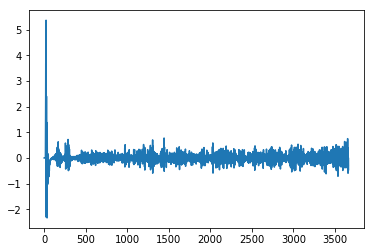

All done, goodbye!
Closing session...
TODO: Prompt save request here


In [7]:
training_data =  gan.train(training_path, examine_sample=10)

INFO:tensorflow:Restoring parameters from model_dir\final\model006.ckpt
Data does not fit generator, resampling...


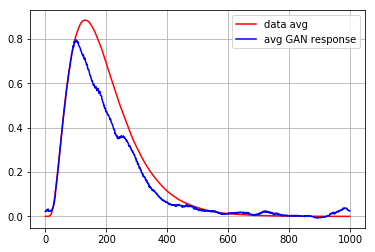

In [10]:
gan_avg, test_avg, IRs = gan.test_compare_avg(testdata_path)

In [11]:
from scipy.interpolate import spline

xnew = np.linspace(0,1000,1)

print(xnew)

[0.]


In [34]:
def softmax(X):
    Y = np.zeros([X.shape[0],X.shape[1]])
    for k in range(X.shape[0]):
        row = X[k,:]
        rowsumexp = np.sum(np.exp(row))
        Y[k,:] = np.exp(row)/rowsumexp
    return Y

# [1,0] FAKE
#
# [0,1] REAL

rdata = gan.generate_data_batch(testdata_path, 2)
fdata,fratings = gan.generate_sample_batch(2)

Data does not fit generator, resampling...
INFO:tensorflow:Restoring parameters from model_dir\final\model005.ckpt


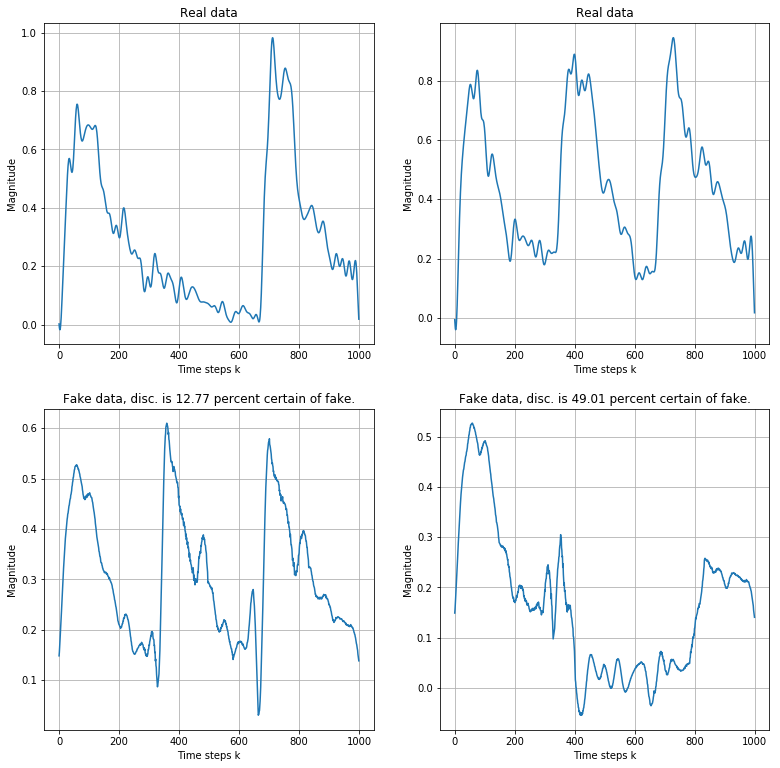

In [35]:
fig = plt.figure(figsize=(13,13))

plt.subplot(2,2,1)
plt.plot(rdata[0,:])
plt.title('Real data')
plt.xlabel('Time steps k')
plt.ylabel('Magnitude')
plt.grid()

plt.subplot(2,2,2)
plt.plot(rdata[1,:])
plt.title('Real data')
plt.xlabel('Time steps k')
plt.ylabel('Magnitude')
plt.grid()

plt.subplot(2,2,3)
plt.plot(fdata[0,:])
plt.title('Fake data, disc. is %.2f percent certain of fake.'%(100*softmax(fratings)[0,0]))
plt.xlabel('Time steps k')
plt.ylabel('Magnitude')
plt.grid()

plt.subplot(2,2,4)
plt.plot(fdata[1,:])
plt.title(softmax(fratings)[1,:])
plt.title('Fake data, disc. is %.2f percent certain of fake.'%(100*softmax(fratings)[1,0]))
plt.xlabel('Time steps k')
plt.ylabel('Magnitude')
plt.grid()


plt.savefig('C:\\Users\\Jan\\Desktop\\a.png')
plt.show()

In [11]:
print(softmax(fratings))

[[0.56772195 0.43227805]
 [0.48484343 0.51515657]]


INFO:tensorflow:Restoring parameters from model_dir\final\model005.ckpt


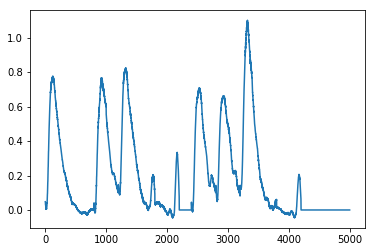

In [21]:
sequ_in = [1,0,1,1,0,0,1,1,1]
gan_out_len = 1000

release_interval = 400

array_in = np.array(sequ_in)

ax = np.zeros([1,array_in.shape[0]*gan_out_len])
impulse_batch,_ = gan.generate_sample_batch(array_in.shape[0])

for k in range(len(sequ_in)):
    impulse = impulse_batch[k,:]
    ax_sub = np.zeros([1,array_in.shape[0]*gan_out_len])
    ax_sub[0,k*release_interval:k*release_interval+gan_out_len] = np.reshape(sequ_in[k]*impulse, (1,gan_out_len))
    ax = ax + ax_sub
    
plt.plot(ax[0,:-4000])
plt.show()